# Read data

In [262]:
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

In [263]:
activity_cols = {
    "Datum": "date",
    "Ø Pace": "activity_pace_average",
    "Kalorien": "activity_calories",
    "Zeit": "activity_duration",
    "Ø Herzfrequenz": "activity_heart_rate_average",
    "Ø Atemfrequenz": "activity_breathing_rate_average",
}
df_activities = pd.read_csv(
    "data/raw/all_activities.csv",
    usecols=list(activity_cols.keys())
)
df_activities.rename(columns=activity_cols, inplace=True)

sleep_cols = {
    "Sleep Score 7 Tage": "date",
    "Score": "sleep_score",
    "Dauer": "sleep_duration",
    "Schlafenszeit": "sleep_bedtime",
    "Ruheherzfrequenz": "sleep_resting_heart_rate",
    "HFV-Status": "sleep_hrv_status",
    "Atmung": "sleep_breathing_rate",
    "Schlafbedürfnis": "sleep_duration_needed",
}
df_sleep = pd.read_csv(
    "data/raw/sleep.csv",
    usecols=list(sleep_cols.keys())
)
df_sleep.rename(columns=sleep_cols, inplace=True)

# Clean data/time features

## Activities

In [264]:
def pace_to_seconds(pace_str):
    try:
        if isinstance(pace_str, str) and ":" in pace_str:
            parts = pace_str.split(":")
            if len(parts) == 2:
                minutes, seconds = int(parts[0]), int(parts[1])
                return minutes * 60 + seconds
            elif len(parts) == 3:  # If format is HH:MM:SS
                hours, minutes, seconds = int(
                    parts[0]), int(parts[1]), int(parts[2])
                return hours * 3600 + minutes * 60 + seconds
        return float(pace_str)
    except Exception:
        return 0


df_activities["date"] = pd.to_datetime(df_activities["date"], errors="coerce")
df_activities["activity_starting_time"] = df_activities["date"] - df_activities["date"].dt.normalize()
df_activities["date"] = df_activities["date"].dt.normalize()

df_activities["activity_pace_average"] = df_activities["activity_pace_average"].apply(pace_to_seconds)
df_activities["activity_duration"] = pd.to_timedelta(df_activities["activity_duration"], errors="coerce")
df_activities["activity_duration_seconds"] = df_activities["activity_duration"].dt.total_seconds().fillna(0).astype(int)

df_activities["activity_ending_time"] = df_activities["activity_starting_time"] + df_activities["activity_duration"]


In [265]:
numeric_columns = [
    "activity_calories",
    "activity_heart_rate_average",
    "activity_pace_average",
    "activity_breathing_rate_average",
]

for col in numeric_columns:
    if df_activities[col].dtype == "object":
        df_activities[col] = pd.to_numeric(df_activities[col].str.replace(',', '').replace('--', '0'), errors='coerce')
    else:
        df_activities[col] = pd.to_numeric(df_activities[col], errors='coerce')

## Sleep

In [266]:
df_sleep["date"] = pd.to_datetime(df_sleep["date"], errors="coerce")

df_sleep = df_sleep[df_sleep["sleep_bedtime"] != "--"]

df_sleep["sleep_bedtime"] = pd.to_timedelta(
    pd.to_datetime(df_sleep["sleep_bedtime"].astype(str), format="%I:%M %p").dt.hour * 3600 +
    pd.to_datetime(df_sleep["sleep_bedtime"].astype(str), format="%I:%M %p").dt.minute * 60,
    unit="s"
)

# Handle AM times by adding 24 hours to times before noon
mask = df_sleep["sleep_bedtime"].dt.components['hours'] < 12
df_sleep.loc[mask, "sleep_bedtime"] = df_sleep.loc[mask, "sleep_bedtime"] + pd.Timedelta(days=1)

df_sleep["sleep_duration"] = pd.to_timedelta(df_sleep["sleep_duration"], errors="coerce")
df_sleep["sleep_duration_seconds"] = (df_sleep["sleep_duration"]).dt.total_seconds()
df_sleep["sleep_duration_needed"] = pd.to_timedelta(df_sleep["sleep_duration_needed"], errors="coerce")
df_sleep["sleep_duration_needed_seconds"] = (df_sleep["sleep_duration_needed"]).dt.total_seconds() 

df_sleep["sleep_duration_needed_delta"] = df_sleep["sleep_duration"] - df_sleep["sleep_duration_needed"]
df_sleep["sleep_duration_needed_delta_seconds"] = (df_sleep["sleep_duration_needed_delta"]).dt.total_seconds()

In [267]:
numeric_columns = [
    "sleep_score",
    "sleep_resting_heart_rate",
    "sleep_hrv_status",
    "sleep_breathing_rate",
]

for col in numeric_columns:
    if df_sleep[col].dtype == "object":
        df_sleep[col] = pd.to_numeric(df_sleep[col].str.replace(',', '').replace('--', '0'), errors='coerce')
    else:
        df_sleep[col] = pd.to_numeric(df_sleep[col], errors='coerce')

## Combined

In [268]:
df_latest_activity = df_activities.sort_values('activity_ending_time').groupby('date', as_index=False).last()

df_combined = pd.merge(df_latest_activity, df_sleep, on='date', how='right')

if "activity_ending_time" in df_combined.columns and "sleep_bedtime" in df_combined.columns:
    df_combined["bedtime_activity_ending_delta"] = df_combined["sleep_bedtime"] - df_combined["activity_ending_time"]


## Save cleaned data

In [261]:
df_combined.to_csv("data/cleaned/combined_activities_sleep.csv", index=False)

# Visualizations

## Corelation Matrix sleep after all trainings

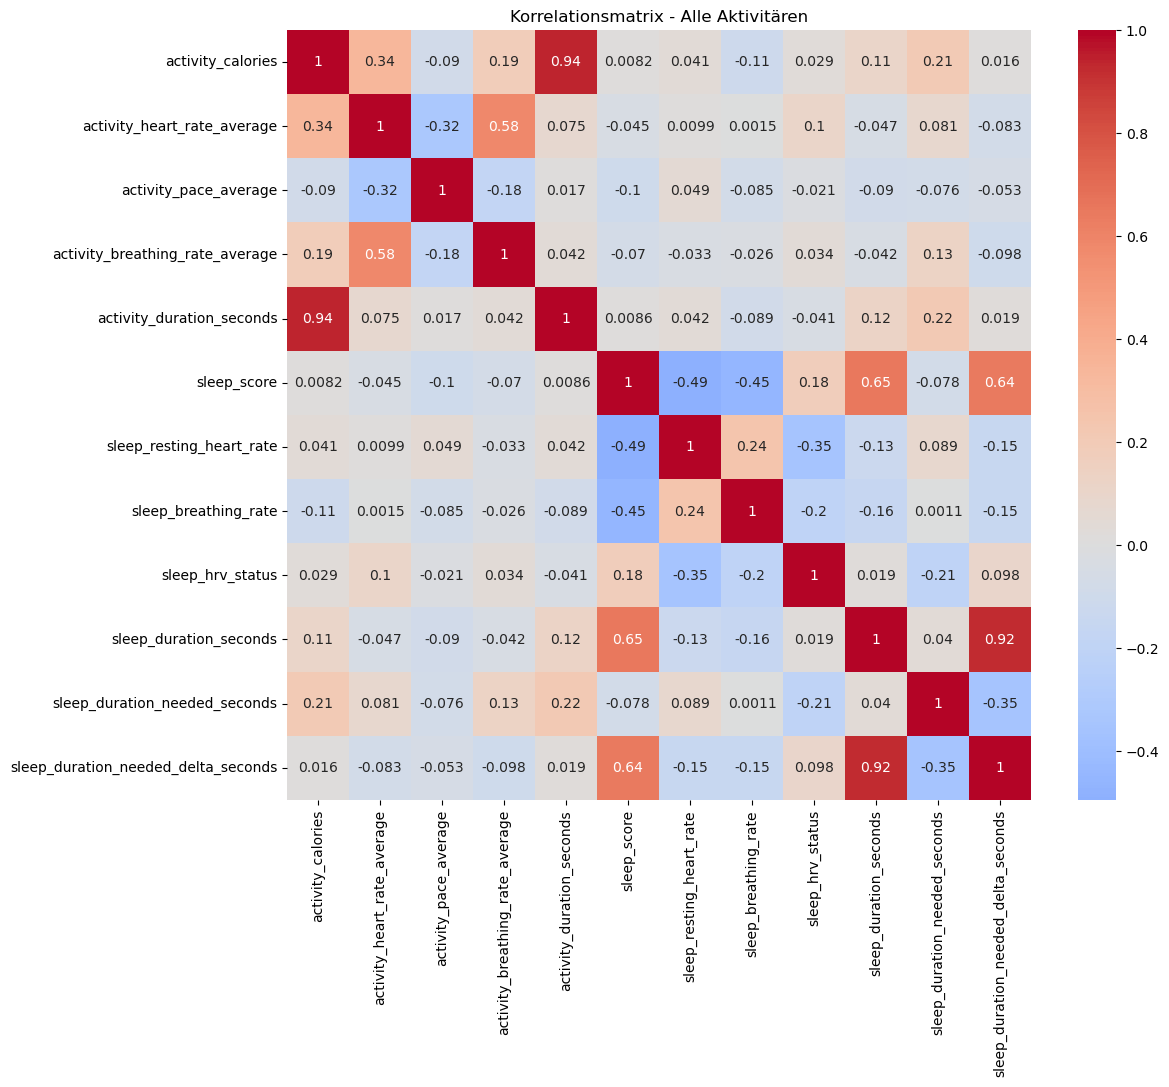

In [269]:
filtered_all_activities = df_combined[(df_combined["activity_calories"].notna())]
correlation_matrix = df_combined.corr(numeric_only=True)

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Korrelationsmatrix - Alle Aktivitären")
plt.show()

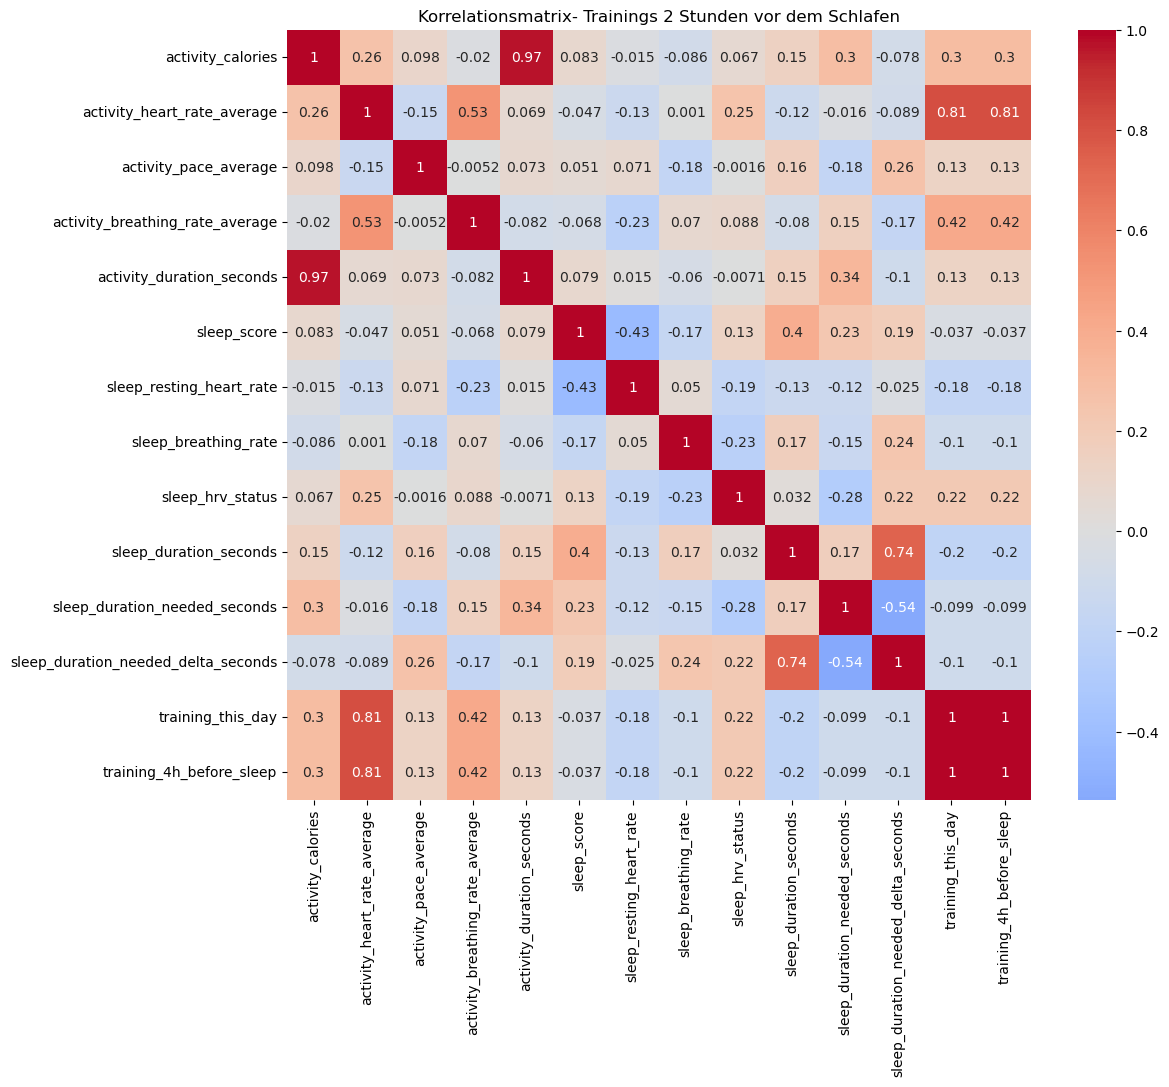

In [ ]:

df_combine_activities_4_hours_before_sleep = df_combined[(df_combined["activity_calories"].notna()) & (
    df_combined["bedtime_activity_ending_delta"] < pd.Timedelta(hours=4))]

correlation_matrix = df_combine_activities_4_hours_before_sleep.corr(
    numeric_only=True)

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Korrelationsmatrix- Trainings 2 Stunden vor dem Schlafen")
plt.show()

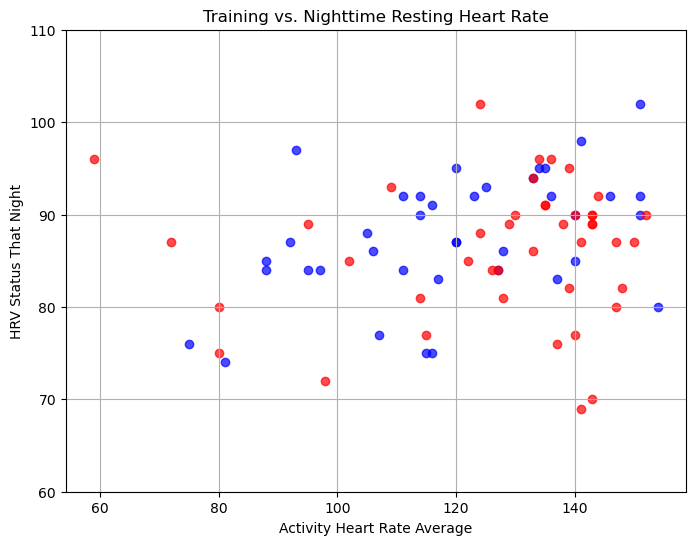

Number of blue points: 39
Number of red points: 43


In [ ]:
import matplotlib.pyplot as plt

filtered_df_combined_4h_before_sleep = df_combine_activities_4_hours_before_sleep[
    (df_combine_activities_4_hours_before_sleep["activity_calories"].notna()) &
    (df_combine_activities_4_hours_before_sleep['sleep_duration_needed_delta'].abs() < pd.Timedelta(hours=0.5))
]
plt.figure(figsize=(8, 6))
plt.scatter(
    filtered_df_combined_4h_before_sleep['activity_heart_rate_average'],
    filtered_df_combined_4h_before_sleep['sleep_hrv_status'],
    alpha=0.7,
    color='blue'
)
filtered_df_combined_more_than_4h_before_sleep = df_combined[
     (df_combined["activity_calories"].notna()) &
     (df_combined["bedtime_activity_ending_delta"] > pd.Timedelta(hours=4))&
     (df_combined['sleep_duration_needed_delta'].abs() < pd.Timedelta(hours=0.25))
 ]

plt.scatter(
    filtered_df_combined_more_than_4h_before_sleep['activity_heart_rate_average'],
    filtered_df_combined_more_than_4h_before_sleep['sleep_hrv_status'],
    alpha=0.7,
    color='red',
    
)
plt.xlabel('Activity Heart Rate Average')
plt.ylabel('HRV Status That Night')
plt.ylim(60, 110)
plt.title('Training vs. Nighttime Resting Heart Rate')
plt.grid(True)
plt.show()



print(f'Number of blue points: {len(filtered_df_combined_4h_before_sleep)}')
print(f'Number of red points: {len(filtered_df_combined_more_than_4h_before_sleep)}')



/var/folders/cp/r09cdjsd4hzc7p8vtlkxw48h0000gn/T/ipykernel_3273/2640708562.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


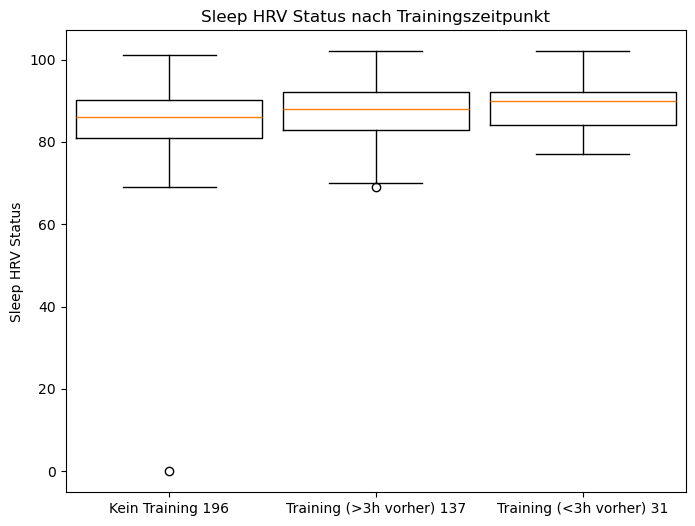

In [226]:

filtered = df_combined
filtered['training_this_day'] = filtered['activity_calories'].notna() & (filtered['activity_heart_rate_average'] > 120)
filtered['training_4h_before_sleep'] = (
    (filtered['training_this_day']) &
    (filtered["bedtime_activity_ending_delta"] < pd.Timedelta(hours=4))
)

group_no_training = filtered[~filtered['training_this_day']]['sleep_hrv_status']
group_training_2h_before_sleep = filtered[filtered['training_4h_before_sleep']]['sleep_hrv_status']
group_training_more_than_2h = filtered[
    filtered['training_this_day'] & ~filtered['training_4h_before_sleep']
]['sleep_hrv_status']


plt.figure(figsize=(8, 6))
plt.boxplot(
    [group_no_training.dropna(), group_training_more_than_2h.dropna(),
     group_training_2h_before_sleep.dropna()],
    labels=['Kein Training ' + str(len(group_no_training.dropna())), 'Training (>3h vorher) ' + str(len(
        group_training_more_than_2h.dropna())), 'Training (<3h vorher) ' + str(len(group_training_2h_before_sleep.dropna()))], widths=0.9
)

plt.ylabel('Sleep HRV Status')

plt.title('Sleep HRV Status nach Trainingszeitpunkt')
plt.show()

In [361]:
import pandas as pd

# Show all rows
pd.set_option('display.max_rows', None)

# Show all columns
pd.set_option('display.max_columns', None)

# Prevent truncation of column content
pd.set_option('display.max_colwidth', None)

# Optional: prevent line wrapping for wide tables
pd.set_option('display.expand_frame_repr', False)

# Now display your DataFrame
filtered  # or use print(df_combined) if needed
len(filtered)




13